# Titanic Survivability Linear Learner in SageMaker

## Prerequisites and Data <a class="anchor" id="pre_and_data">
### Initialize SageMaker  <a class="anchor" id="initsagemaker">
Add the data files for training set, test set and validation set

In [10]:
from sagemaker import Session
bucket = 'ml-i6-breakingcode'
prefix = 'sagemaker/ebsco-titanic-survivabiity'

# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import urllib
import os
import sklearn.preprocessing as preprocessing
import seaborn as sns

role = get_execution_role()
data_key = 'train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
training_set = pd.read_csv(data_location)
print("1. finished uploading training set")

data_key = 'test.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
test_set = pd.read_csv(data_location)
print("2. finished uploading test set")

data_key = 'gender_submission.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
validation_set= pd.read_csv(data_location)
print("3. finished uploading validation set")

1. finished uploading training set
2. finished uploading test set
3. finished uploading validation set


### Data Manipulation <a class="anchor" id="inspect_data">
Remove columns that doesn't affect the analysis from the training set

In [26]:
clean_training_data = training_set.drop("Name", axis = 1)
clean_training_data.head()
clean_training_data = clean_training_data.drop("Ticket", axis = 1)
clean_training_data.head()
clean_training_data = clean_training_data.drop("Cabin", axis = 1)
clean_training_data.head()
clean_training_data = clean_training_data.drop("PassengerId", axis = 1)
clean_training_data.head()
clean_training_data = pd.get_dummies(clean_training_data, columns = ["Sex"])
clean_training_data.head()
clean_training_data = pd.get_dummies(clean_training_data, columns = ["Embarked"])
clean_training_data.head()
clean_training_data = clean_training_data.dropna(how='any',axis = 0)
clean_training_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


### Data inspection  <a class="anchor" id="inspect_data">
Plotting histograms of the distribution of the different features is a good way to visualize the data. We plot both the whole dataset distributions (left) and the distrubtions in the case of positive labels only (right).

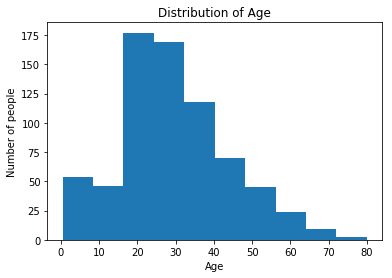

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

data = clean_training_data['Age']

data.plot(kind='hist')
plt.ylabel('Number of people')
plt.xlabel('Age')
plt.title('Distribution of Age')
plt.show()

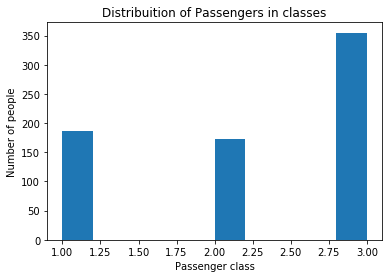

In [33]:
data = clean_training_data['Pclass']

data.plot(kind='hist')
plt.ylabel('Number of people')
plt.xlabel('Passenger class')
plt.title('Distribuition of Passengers in classes')
plt.show()

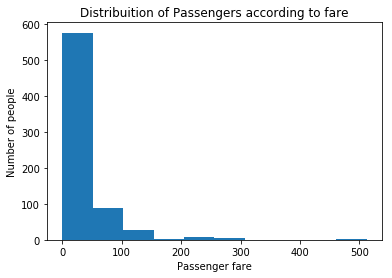

In [35]:
data = clean_training_data['Fare']

data.plot(kind='hist')
plt.ylabel('Number of people')
plt.xlabel('Passenger fare')
plt.title('Distribuition of Passengers according to fare')
plt.show()

### Data encoding   <a class="anchor" id="encode_data">
We apply a preprocessing encoder for the categorial features.

In [ ]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna('None'))
    return result, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(original_data)
training_data_matrix = np.array(encoded_data.values, dtype=float)
encoded_data, _ = number_encode_features(original_test)
test_data_matrix = np.array(encoded_data.fillna(0).values, dtype=float)

scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
training_data_matrix = scaler.fit_transform(training_data_matrix)
test_data_matrix = scaler.transform(test_data_matrix)

### Data conversion and upload of the training data    <a class="anchor" id="upload_data">

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

We also need to upload it to S3, so that Amazon SageMaker training can use it.

In [ ]:
import io
import numpy as np
import sagemaker.amazon.common as smac
import boto3
import os

vectors = np.array([t.tolist() for t in training_data_matrix[:,:-1]]).astype('float32')
labels = np.where(np.array([t.tolist() for t in training_data_matrix[:,-1]]) == 1, 1, 0).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [ ]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

## Standard linear model  <a class="anchor" id="train_linear_model">

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker

container = get_image_uri(boto3.Session().region_name, 'linear-learner', "latest")

sess = sagemaker.Session()
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=14,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

### Accuracy and Fairness of the model <a class="anchor" id="performance_linear_model">
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')


linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Prediction for the test data.

In [ ]:
import numpy as np

predictions = []
distance_from_hyperplane = []
for array in np.array_split(test_data_matrix[:,:-1], 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]
    distance_from_hyperplane += [r['score'] for r in result['predictions']]

predictions_test = np.array(predictions)
distance_from_hyperplane_test = np.array(distance_from_hyperplane)    

import pandas as pd

pd.crosstab(np.where(test_data_matrix[:,-1] == 1, 1, 0), predictions_test,
            rownames=['actuals'], colnames=['predictions'])

We selcted as sensitive feature the gender, dividing the data between "female" and "male". Let's check if our model is fair (in the sense of Equal Opportunity). In the following the performance concerning Accuracy, True Positive Rate (among the two groups and the whole dataset) and DEO.

In [ ]:
sensitive_feature_gender = 9  # Gender
groupA_value = 0.0 # Female

deo = deo_from_model(linear_predictor, test_data_matrix,
                     sensitive_feature_gender, groupA_value=groupA_value)
print('DEO: %f' % deo)

A DEO of about $0.24$ is quite high, this means that there is a large gap between the True Positive Rate of the group A (female) and the group B (male) and cosequently there is not Equal Opportunity. 

In other words, we can say that for every $100$ correctly predicted positive examples in one group, the disadvantage group will have only $100 - 24 = 76$  of them. Consequently, it is clear that the distribution of the error is unfair, and our goal now is to solve this unfairness maintaining a comparable prediction accuracy.

## Changing the data to impose fairness <a class="anchor" id="impose_fairness">

In the case of linear model, there is a simple but powerful way to impose the fairness constraint$^{[3]}$, i.e. $DEO(f) = 0$. Firstly, we have to introduce the following vector $u$:

$$ u = \frac{1}{n(+, A)} \sum_{x \in X(+, A)} x - \frac{1}{n(+, B)} \sum_{x \in X(+, B)} x,$$

where $X(+, A)$ and $X(+, B)$ are the sets of positively labeled examples in group $A$ and $B$ and $n(+, A)$ and $n(+, B)$ their cardinalities. The vector $u$ represents the unfair model, and our goal is to impose a serach space of the models that is orthogonal to it. In the implementation we consider, without loss of generality, that the binary sensitive feature is $0$ for the gorup A and $+1$ for group B.

In our linear case, we can impose this orthogonal constraint, i.e. impose the fairness, by applying a preprocessing of the original data as following:

$$ \hat{x}_j = x_j - x_i \frac{u_j}{u_i} \,\,\,\, j \in \{1, \dots, i-1, i+1, \dots, d\}.$$
Where $i$ is the index of the sensitive feature and $\hat{x}_j$ is the new value for the feature $j^{th}$. It is important to note that - as consequence of this method - the new data representation has a $1$ feature less compared the original one (in our case the sensitive feature).

$^{[3]}$Michele Donini, et al. "[Empirical Risk Minimization under Fairness Constraints](https://arxiv.org/abs/1802.08626)." arXiv preprint arXiv:1802.08626 (2018).

In [ ]:
class UncorrelationMethod:
    def __init__(self, sensitive_feature, groupA_value=0.0):
        self.val0 = groupA_value
        self.sensitive_feature = sensitive_feature
        self.u = None

    def new_representation(self, examples):
        if self.u is None:
            print('You have to fit the model first...')
            return examples
        new_examples = np.array([ex if ex[self.sensitive_feature] == self.val0 # case x_i = 0, Group A
                                 else ex + self.u for ex in examples]) # case x_i = 1, Group B
        new_examples = np.delete(new_examples, self.sensitive_feature, 1)
        return new_examples
    
    def fit(self, dataset):
        tmp = [ex for idx, ex in enumerate(dataset)
               if dataset[idx, -1] == 1 and ex[self.sensitive_feature] == self.val0]
        average_A_1 = np.mean(tmp, 0)
        n_A_1 = len(tmp)
        tmp = [ex for idx, ex in enumerate(dataset)
               if dataset[idx, -1] == 1 and ex[self.sensitive_feature] != self.val0]
        average_not_A_1 = np.mean(tmp, 0)
        n_not_A_1 = len(tmp)
        N_1 = len([ex for idx, ex in enumerate(dataset) if dataset[idx, -1] == 1])
        self.u = average_A_1[:-1] - average_not_A_1[:-1]
        # Our hypothesis of values 0 (A) and +1 (B) for the sensitive feature among the two groups
        # has the following consequence:
        self.u[self.sensitive_feature] = -1.0

At this point we are ready to apply this algorithm to our data.

In [ ]:
uncorr_data = UncorrelationMethod(sensitive_feature_gender, 0.0)
uncorr_data.fit(training_data_matrix) 
new_training_data_matrix = np.hstack([uncorr_data.new_representation(training_data_matrix[:, :-1]),
                                     training_data_matrix[:, -1:-2:-1]])
new_test_data_matrix = np.hstack([uncorr_data.new_representation(test_data_matrix[:, :-1]),
                                  test_data_matrix[:, -1:-2:-1]])

### Train the model with the fair data <a class="anchor" id="train_fair_model">

Now we have simply to repeat the training by using this new dataset. It is important to note that the new dataset has one feature less than the original one ($13$ instead of $14$).

In [ ]:
vectors = np.array([t.tolist() for t in new_training_data_matrix[:,:-1]]).astype('float32')
labels = np.where(np.array([t.tolist() for t in new_training_data_matrix[:,-1]]) == 1, 1, 0).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

linearf = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linearf.set_hyperparameters(feature_dim=13,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

path_fair_model = linearf.fit({'train': s3_train_data})

linear_predictorf = linearf.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')
linear_predictorf.content_type = 'text/csv'
linear_predictorf.serializer = csv_serializer
linear_predictorf.deserializer = json_deserializer

Now, we can calculate the predictions using our fair linear model.

In [ ]:
predictions = []
distance_from_hyperplane = []
for array in np.array_split(new_test_data_matrix[:,:-1], 100):
    result = linear_predictorf.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]
    distance_from_hyperplane += [r['score'] for r in result['predictions']]

distance_from_hyperplane_test_fair = np.array(distance_from_hyperplane)    
predictions_test_fair = np.array(predictions)
pd.crosstab(np.where(new_test_data_matrix[:,-1] == 1, 1, 0), predictions_test_fair,
            rownames=['actuals'], colnames=['predictions'])

### Accuracy and Fairness of the fair model <a class="anchor" id="performance_fair_model">
Let's see the performance concerning accuracy and fairness for our new model. We selcted as sensitive feature the Gender, dividing the data between "female" and "male".

In [ ]:
groupA_idxs = [idx for idx, val in enumerate(test_data_matrix)
               if val[sensitive_feature_gender] == groupA_value]
groupB_idxs = [idx for idx, val in enumerate(test_data_matrix)
               if val[sensitive_feature_gender] != groupA_value]
deo = deo_from_list(new_test_data_matrix, predictions_test_fair, groupA_idxs, groupB_idxs)
print('DEO: %f' % deo)

The comparison with respect to the original model is the following:
- Concerning the accuracy the difference is not significative. In fact, from an original $0.8235$ of accuracy, we obtain $0.8086$ (decrease of about $1.8 \%$).
- Concerning the DEO, the original model has a level of unfairness of $0.2404$ and our fair model of $0.0612$, with a decrese of more than $75 \%$.

## Sanity check: performance on the training set  <a class="anchor" id="performance_fair_model_train">

Let's see the performance of our method on the training set in order to see if we apply the correct constraint and we do not overfit the data.

In [ ]:
predictions = []
distance_from_hyperplane = []
for array in np.array_split(new_training_data_matrix[:,:-1], 100):
    result = linear_predictorf.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]
    distance_from_hyperplane += [r['score'] for r in result['predictions']]

distance_from_hyperplane_train_fair = np.array(distance_from_hyperplane)    
predictions_train_fair = np.array(predictions)
pd.crosstab(np.where(new_training_data_matrix[:,-1] == 1, 1, 0),
            predictions_train_fair, rownames=['actuals'], colnames=['predictions'])

groupA_idxs = [idx for idx, val in enumerate(training_data_matrix)
               if val[sensitive_feature_gender] == groupA_value]
groupB_idxs = [idx for idx, val in enumerate(training_data_matrix)
               if val[sensitive_feature_gender] != groupA_value]

deo = deo_from_list(new_training_data_matrix, predictions_train_fair, groupA_idxs, groupB_idxs)
print('DEO: %f' % deo)

The value of the DEO is 0.0097. This confirm that our method is able to implement the fairness constraint in the linear case.

## Distribution of the outputs <a class="anchor" id="distrib">

Now we plot the values of $\langle w,x \rangle - b$ for all the examples $x$ with $y=1$, where $w$ is the trained model, for both the original model and our fair one. The value $\langle w,x \rangle - b$ can be considered as the distance of $x$ from the hyperplane that divides our feature space between positive and negative examples. When this value is positive means that our classifier predicts a positive label for the example $x$. Consequently, the area of the histogram is a visualization of the True Positive Rate (the difference between the blue and orange areas is an approximation of the DEO). For this reason, similar blue and orange areas measn a more fair model (with respect to the senstive feature "gender").

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)
sagemaker.Session().delete_endpoint(linear_predictorf.endpoint)

Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.  Licensed under the Apache License, Version 2.0 (the \"License\"). You may not use this file except in compliance with the License. A copy of the License is located at http://aws.amazon.com/apache2.0/ or in the \"license\" file accompanying this file. This file is distributed on an \"AS IS\" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.